[Info] Sum of weights is 100.0, assuming percentage and dividing by 100
归一化权重: {'sh518860': 0.3, 'sh513880': 0.03, 'sh513310': 0.03, 'sh516780': 0.04, 'sh513630': 0.1, 'sh511260': 0.2, 'sh513870': 0.2, 'sh513650': 0.1}
开始数据下载...

处理 sh518860 (GLD_ETF)...
下载 sh518860 数据...
下载 sh518860 数据...
  尝试方法: fund_etf_hist_em (纯数字), 代码: 518860
  方法 fund_etf_hist_em (纯数字) 失败: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
  尝试方法: fund_etf_hist_sina, 代码: sh518860
  方法 fund_etf_hist_sina 成功
原始列名: ['date', 'open', 'high', 'low', 'close', 'volume']
处理后列名: ['date', 'open', 'high', 'low', 'close', 'volume']
重命名后列名: ['date', 'open', 'high', 'low', 'close', 'volume']
保存 sh518860 到缓存, 1303 行
  数据范围: 2020-09-07 到 2026-01-29, 1303 行

处理 sh513880 (RI_ETF)...
下载 sh513880 数据...
下载 sh513880 数据...
  尝试方法: fund_etf_hist_em (纯数字), 代码: 513880
  方法 fund_etf_hist_em (纯数字) 失败: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
  尝试方法

,Weight
GLD_ETF,0.30
RI_ETF,0.03
DAOTI_ETF,0.03
EARTH_ETF,0.04
HSHL_ETF,0.10
GUOZAI_ETF,0.20
NASDAQ_ETF,0.20
SPY_BENCHMARK,0.10


,Value
Total Annualized Return,42.94%
Total Return,44.77%
Sharpe (Rf=3%),283.29%
Volatility (ann.),11.81%
Max Drawdown,-6.88%
"Alpha (annual, vs sh513600)",24.00%
Beta (vs sh513600),31.96%
Trades,200.00%
Win Rate,100.00%
YTD,10.03%



== 年度统计 ==


,Year,AnnualizedReturn,TotalReturn
0,2025,30.82%,29.57%
1,2026,255.25%,10.03%



== 季度收益率 (季度末) ==


,Quarter,Return
0,2025Q1,1.74%
1,2025Q2,7.01%
2,2025Q3,10.52%
3,2025Q4,3.20%
4,2026Q1,10.03%



== 季度选择的基金 ==


,Quarter,Selected
0,2025Q1,"[GLD_ETF, RI_ETF, DAOTI_ETF, EARTH_ETF, HSHL_E..."
1,2025Q2,"[GLD_ETF, RI_ETF, DAOTI_ETF, EARTH_ETF, HSHL_E..."
2,2025Q3,"[GLD_ETF, RI_ETF, DAOTI_ETF, EARTH_ETF, HSHL_E..."
3,2025Q4,"[GLD_ETF, RI_ETF, DAOTI_ETF, EARTH_ETF, HSHL_E..."
4,2026Q1,"[GLD_ETF, RI_ETF, DAOTI_ETF, EARTH_ETF, HSHL_E..."



== 交易记录 ==


,date,turnover,commission
0,2025-01-03 00:00:00,"¥10,000.00",¥10.00
1,2026-01-06 00:00:00,"¥2,521.17",¥2.52



== 区间收益率 (再平衡期间) ==


,start,end,return
0,2025-01-03,2026-01-06,32.76%
1,2026-01-06,2026-01-29,9.05%


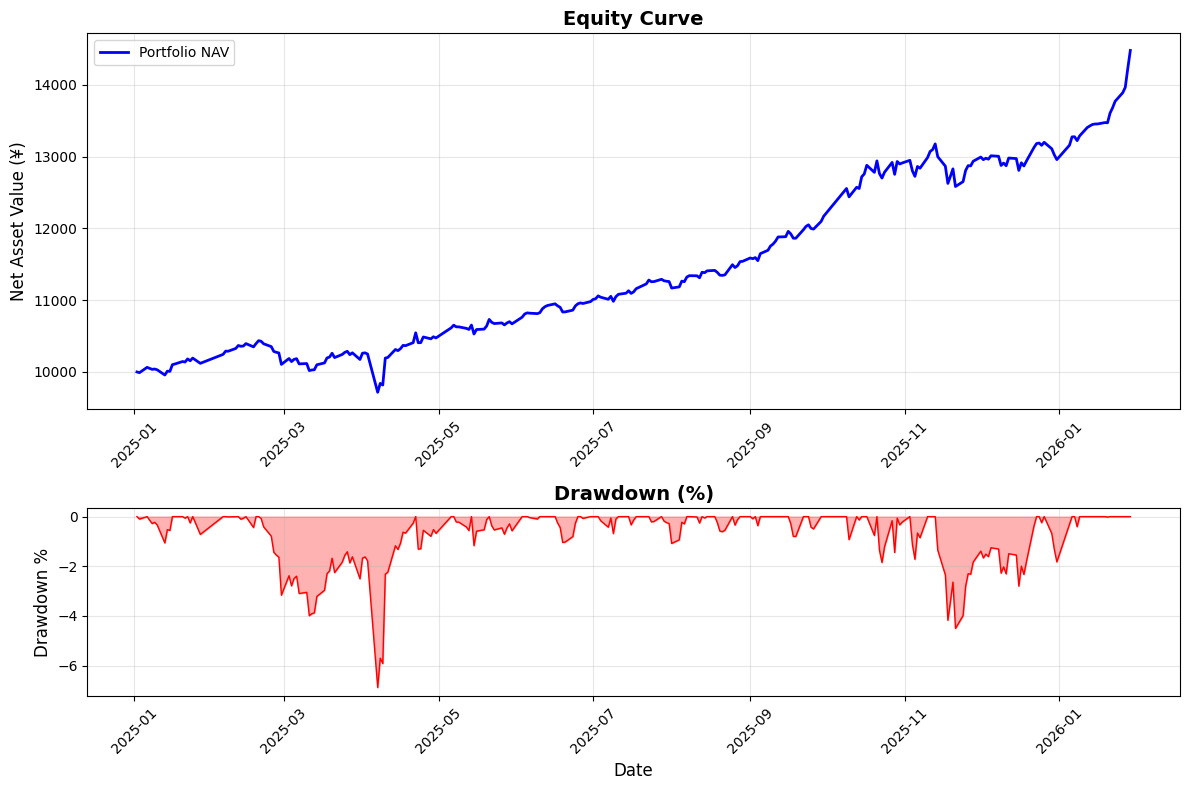

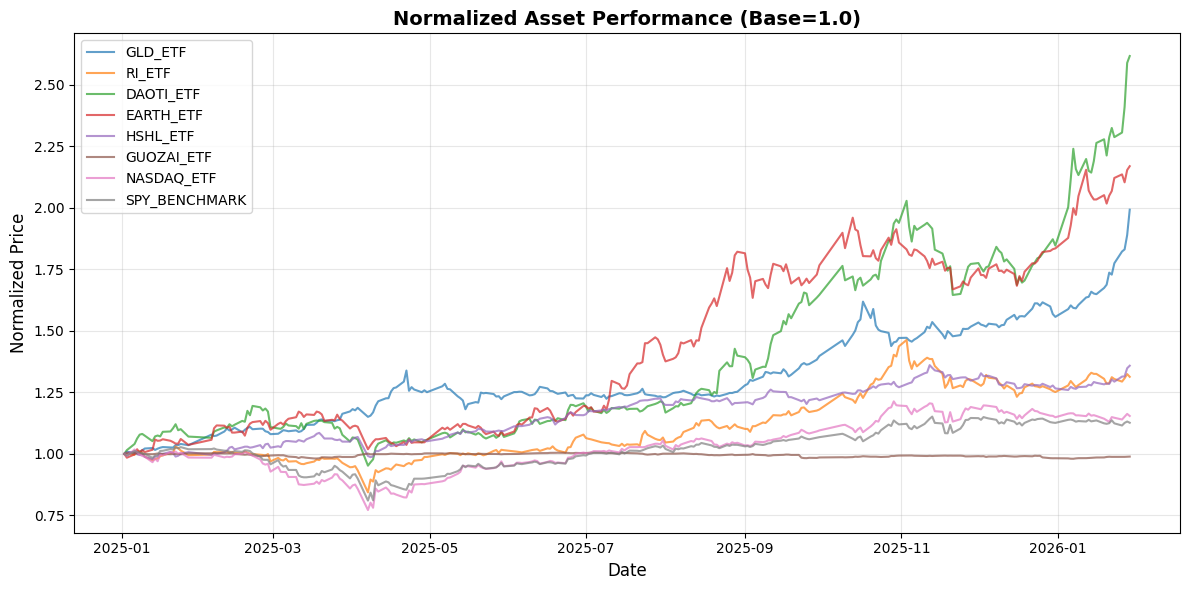


回测完成!


In [4]:
# -*- coding: utf-8 -*-
# Jupyter: Custom weights (by code), ANNUAL rebalance (t+1), trading-day only
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= Global Config =================
START_DATE   = '2025-01-01'
END_DATE     = '2026-01-30'
INITIAL_CASH = 10000.0
COMMISSION   = 0.001       # 0.1% per trade
RF_ANNUAL    = 0.03        # risk-free for Sharpe / alpha
DATA_DIR     = "./data/20250101_20260130"
os.makedirs(DATA_DIR, exist_ok=True)

# 资产映射：股票代码 -> 描述名称（展示用）
ASSET_NAME_MAP = {
    'sh518860': 'GLD_ETF',      # 黄金ETF
    # 'sz159687': 'YATAI_ETF',    # 亚太ETF
    'sh513880' : 'RI_ETF',
    'sh513310' : 'DAOTI_ETF',
    'sh516780' : 'EARTH_ETF',
    'sh513630': 'HSHL_ETF',     # 红利ETF
    'sh511260': 'GUOZAI_ETF',   # 国债ETF
    'sh513870': 'NASDAQ_ETF',   # 纳指ETF（替换QQQ）
    'sh513650': 'SPY_BENCHMARK' # 标普500ETF（替换SPY，作为基准）
}
CODES = list(ASSET_NAME_MAP.keys())       # 交易/下载使用代码
CODE2NAME = ASSET_NAME_MAP.copy()         # 显示使用描述
NAME2CODE = {v:k for k,v in CODE2NAME.items()}

# ----------- 自定义权重（按股票代码填写） -----------
# 可用比例或百分比（总和≈1 或 ≈100 均可），脚本会归一化
WEIGHTS_USER = {
    'sh518860': 30,   # 黄金ETF
    # 'sz159687': 00,   # 亚太ETF
    'sh513880': 3,   # 日经ETF
    'sh513310': 3,   # 半导体ETF
    'sh516780': 4,   # 稀土ETF
    'sh513630': 10,   # 红利ETF
    'sh511260': 20,   # 国债ETF
    'sh513870': 20,   # 纳指ETF
    'sh513650': 10    # 标普500ETF（投资组合的一部分，也作为基准）
}
# -------------------------------------------------

# ================= Utilities: IO & Normalize =================
def csv_path(code: str) -> str:
    return os.path.join(DATA_DIR, f"{code}.csv")

def ensure_columns_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize to: date, open, high, low, close, volume
    - Robust to non-string / tuple column names
    - Accepts common Chinese headers
    - Drops rows without close; ensures YYYY-MM-DD for CSV
    """
    if df is None or df.empty:
        return pd.DataFrame()
    
    df = df.copy()
    
    # 打印原始列名以调试
    print(f"原始列名: {list(df.columns)}")
    
    # 将列名转换为字符串并统一为小写，去除空格
    df.columns = [str(col).strip().lower() for col in df.columns]
    print(f"处理后列名: {list(df.columns)}")
    
    # 更灵活地识别列名
    rename_dict = {}
    
    # 识别日期列 - 添加更多可能的日期列名
    date_patterns = ['date', '时间', '日期', '交易日期', 'datetime', 'time', 'day']
    date_col = None
    for col in df.columns:
        col_lower = col.lower()
        for pattern in date_patterns:
            if pattern in col_lower:
                date_col = col
                rename_dict[col] = 'date'
                break
        if date_col:
            break
    
    if not date_col:
        # 如果没有找到日期列，尝试第一列
        if len(df.columns) > 0:
            rename_dict[df.columns[0]] = 'date'
    
    # 识别价格列
    price_mappings = {
        'open': ['open', '开盘', '开盘价', 'open'],
        'high': ['high', '最高', '最高价', 'high'],
        'low': ['low', '最低', '最低价', 'low'],
        'close': ['close', '收盘', '收盘价', 'close', 'adj close'],
        'volume': ['volume', '成交量', '成交额', 'vol', 'amount', '成交']
    }
    
    for target_col, patterns in price_mappings.items():
        for col in df.columns:
            if col in rename_dict:  # 已重命名
                continue
            col_lower = col.lower()
            for pattern in patterns:
                if pattern in col_lower:
                    rename_dict[col] = target_col
                    break
            if col in rename_dict:
                break
    
    # 应用重命名
    df = df.rename(columns=rename_dict)
    print(f"重命名后列名: {list(df.columns)}")
    
    # 确保有必要的列
    required_cols = ['date']
    available_cols = [col for col in ['date', 'open', 'high', 'low', 'close', 'volume'] if col in df.columns]
    
    df = df[available_cols].copy()
    
    # 处理日期列
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).sort_values('date').drop_duplicates('date', keep='last')
    
    # 处理数值列
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 确保有close列
    if 'close' not in df.columns:
        # 尝试使用最后一个价格列作为close
        for col in ['close', '收盘', '收盘价', 'adj close']:
            if col in df.columns:
                df['close'] = df[col]
                break
    
    if 'close' not in df.columns and len(df.columns) > 1:
        # 使用第二个数值列作为close
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            df['close'] = df[numeric_cols[0]]
    
    if 'close' not in df.columns or df.empty:
        print("警告: 没有有效的收盘价数据")
        return pd.DataFrame()
    
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    return df

def download_akshare_etf(code: str, start: str, end: str) -> pd.DataFrame:
    """
    下载ETF数据，支持带市场前缀的代码（如sz159934, sh511260）
    """
    import akshare as ak
    
    print(f"下载 {code} 数据...")
    
    # 尝试多种方法获取数据
    methods = []
    
    # 方法1: fund_etf_hist_em (可能需要纯数字代码)
    try:
        # 提取纯数字代码（如果包含市场前缀）
        if code.startswith('sz') or code.startswith('sh'):
            pure_code = code[2:]  # 去掉市场前缀
            methods.append(('fund_etf_hist_em (纯数字)', pure_code))
        else:
            methods.append(('fund_etf_hist_em', code))
    except:
        pass
    
    # 方法2: fund_etf_hist_sina (可能接受带前缀的代码)
    methods.append(('fund_etf_hist_sina', code))
    
    # 方法3: fund_etf_hist_sina (纯数字)
    if code.startswith('sz') or code.startswith('sh'):
        pure_code = code[2:]
        methods.append(('fund_etf_hist_sina (纯数字)', pure_code))
    
    df = None
    last_error = None
    
    for method_name, method_code in methods:
        try:
            print(f"  尝试方法: {method_name}, 代码: {method_code}")
            
            if method_name.startswith('fund_etf_hist_em'):
                df = ak.fund_etf_hist_em(
                    symbol=method_code, period="daily",
                    start_date=start.replace('-', ''),
                    end_date=end.replace('-', ''),
                    adjust="qfq"  # 前复权
                )
            elif method_name.startswith('fund_etf_hist_sina'):
                df = ak.fund_etf_hist_sina(symbol=method_code)
            
            if df is not None and not df.empty:
                print(f"  方法 {method_name} 成功")
                break
                
        except Exception as e:
            last_error = str(e)
            print(f"  方法 {method_name} 失败: {e}")
            continue
    
    if df is None or df.empty:
        print(f"所有方法都失败，最后错误: {last_error}")
        return pd.DataFrame()
    
    return df

def load_or_download(code: str, start: str, end: str) -> pd.DataFrame:
    """Read cache; else download using akshare, save CSV and return."""
    path = csv_path(code)
    
    # 尝试读取缓存
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df = ensure_columns_ohlcv(df)
            if not df.empty:
                df['date'] = pd.to_datetime(df['date'])
                m = (df['date'] >= pd.to_datetime(start)) & (df['date'] <= pd.to_datetime(end))
                df = df.loc[m].copy()
                if not df.empty:
                    print(f"从缓存加载 {code}, {len(df)} 行")
                    return df
        except Exception as e:
            print(f"读取缓存 {code} 错误: {e}")
    
    # 下载数据
    print(f"下载 {code} 数据...")
    df = download_akshare_etf(code, start, end)
    
    if df is None or df.empty:
        print(f"{code} 无数据下载")
        return pd.DataFrame()
    
    # 标准化列名
    df = ensure_columns_ohlcv(df)
    
    if df.empty:
        print(f"{code} 标准化后无数据")
        return pd.DataFrame()
    
    # 保存到缓存
    try:
        df.to_csv(path, index=False)
        print(f"保存 {code} 到缓存, {len(df)} 行")
    except Exception as e:
        print(f"保存缓存 {code} 错误: {e}")
    
    return df

def normalize_weights_by_code(weights_user: dict, codes: list) -> dict:
    """Normalize user weights dict keyed by code; return dict(code->weight in [0,1], sum=1)."""
    w = pd.Series(weights_user, dtype=float).reindex(codes).fillna(0.0)
    s = w.sum()
    if s <= 0:
        w[:] = 1.0/len(codes)
        print("[Info] Provided weights sum to 0. Using equal-weight.")
    else:
        # 如果总和是100左右的数字，假设是百分比
        if 90 < s < 110:
            print(f"[Info] Sum of weights is {s}, assuming percentage and dividing by 100")
            w = w / 100
        w = w.clip(lower=0)
        w = w / w.sum()
    
    zeros = w[w==0]
    if len(zeros) > 0:
        print(f"[Warn] Zero weight for: {list(zeros.index)}")
    
    print(f"归一化权重: {w.to_dict()}")
    return w.to_dict()

WEIGHTS_CODE = normalize_weights_by_code(WEIGHTS_USER, CODES)  # 内部按代码

# ================== Data Ingestion ==================
def get_all_price_series(codes, start, end):
    data = {}
    for code in codes:
        print(f"\n处理 {code} ({CODE2NAME.get(code, code)})...")
        df = load_or_download(code, start, end)
        if df.empty:
            print(f"警告: {code} 无数据，跳过...")
            continue
            
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        data[code] = df[['open','high','low','close','volume']].copy()
        print(f"  数据范围: {df.index[0].date()} 到 {df.index[-1].date()}, {len(df)} 行")
    
    return data

print("=" * 50)
print("开始数据下载...")
prices_dict = get_all_price_series(CODES, START_DATE, END_DATE)

# 检查哪些资产没有数据
missing_codes = [code for code in CODES if code not in prices_dict]
if missing_codes:
    print(f"\n警告: 以下代码缺失数据: {missing_codes}")
    print("从投资组合中移除...")
    CODES = [code for code in CODES if code not in missing_codes]
    CODE2NAME = {code: name for code, name in CODE2NAME.items() if code not in missing_codes}
    WEIGHTS_CODE = normalize_weights_by_code(WEIGHTS_CODE, CODES)

if not CODES:
    raise RuntimeError("没有有效的资产数据!")

print(f"\n有效资产: {CODES}")

# Global trading-day index (union of bars across all assets; no natural days)
all_trading_days = pd.Index(sorted(set().union(*[df.index for df in prices_dict.values()])))

# Close matrix aligned on global trading days; forward-fill per asset
close_code = pd.DataFrame(index=all_trading_days, columns=CODES, dtype=float)
for code, df in prices_dict.items():
    close_code.loc[df.index, code] = df['close']
    
# 前向填充并删除全是NaN的行
close_code = close_code.ffill().dropna(how='all')

# 删除有NaN的行（确保所有资产都有数据）
close_code = close_code.dropna(how='any')

close_code = close_code.loc[
    (close_code.index >= pd.to_datetime(START_DATE)) &
    (close_code.index <= pd.to_datetime(END_DATE))
]

print(f"\n最终数据形状: {close_code.shape}")
print(f"日期范围: {close_code.index[0].date()} 到 {close_code.index[-1].date()}")

# 一个名字版（仅用于展示/输出；内部计算仍可按代码更稳）
close_name = close_code.rename(columns=CODE2NAME)

# ================ Annual Rebalance (t+1) ================
def first_trading_day_of_years(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    df = pd.DataFrame(index=idx); df['Y'] = df.index.year
    firsts = df.groupby('Y').apply(lambda x: x.index.min())
    return pd.DatetimeIndex(firsts.values)

def next_trading_day(idx: pd.DatetimeIndex, dt: pd.Timestamp):
    pos = idx.searchsorted(dt, side='right')
    return None if pos >= len(idx) else idx[pos]

year_first_days = first_trading_day_of_years(close_code.index)
trade_dates = pd.DatetimeIndex(sorted(set(filter(
    None, (next_trading_day(close_code.index, yd) for yd in year_first_days)
))))
trade_dates = trade_dates[
    (trade_dates >= close_code.index.min()) & (trade_dates <= close_code.index.max())
]

print(f"\n再平衡日期 (t+1): {trade_dates.tolist()}")

# ================ Backtest (annual t+1, fixed custom weights) ================
def run_backtest(close_df_code: pd.DataFrame, weights_code: dict,
                 trade_dates: pd.DatetimeIndex,
                 initial_cash=INITIAL_CASH, commission=COMMISSION):
    codes = list(close_df_code.columns)
    w_vec = pd.Series(weights_code).reindex(codes).fillna(0.0)

    cash = initial_cash
    shares = pd.Series(0.0, index=codes)
    equity_curve = pd.Series(index=close_df_code.index, dtype=float)
    positions_value = pd.Series(index=close_df_code.index, dtype=float)

    trade_records, period_pnls = [], []
    last_trade_nav, last_trade_date = None, None

    for dt in close_df_code.index:
        prices = close_df_code.loc[dt, codes]

        if dt in trade_dates:
            total_equity = cash + np.nansum(shares.values * prices.values)
            target_value = total_equity * w_vec
            current_value = shares * prices
            trade_value = target_value - current_value
            turnover = float(np.nansum(np.abs(trade_value.values)))
            cost = turnover * commission

            cash = cash - np.nansum(trade_value.values) - cost
            # 避免除以0
            price_nonzero = prices.replace(0, np.nan)
            shares = (target_value / price_nonzero).fillna(shares)  # 保持原有持仓如果价格为0

            trade_records.append({'date': dt, 'turnover': turnover, 'commission': float(cost)})

            if last_trade_nav is not None:
                period_return = (total_equity - last_trade_nav) / last_trade_nav
                period_pnls.append({'start': last_trade_date, 'end': dt, 'return': float(period_return)})
            last_trade_nav, last_trade_date = total_equity, dt

        port_val = float(np.nansum(shares.values * prices.values))
        positions_value[dt] = port_val
        equity_curve[dt] = cash + port_val

    if last_trade_nav is not None:
        final_nav = equity_curve.iloc[-1]
        period_return = (final_nav - last_trade_nav) / last_trade_nav
        period_pnls.append({'start': last_trade_date, 'end': equity_curve.index[-1], 'return': float(period_return)})

    daily_ret = equity_curve.pct_change().dropna()

    # Quarterly returns (quarter-end only, for reporting only)
    q_df = pd.DataFrame({'nav': equity_curve})
    q_df['Q'] = q_df.index.to_period('Q')
    q_end_nav = q_df.groupby('Q').tail(1)
    q_start_nav = q_df.groupby('Q').head(1)
    q_returns = []
    for yq, end_row in q_end_nav.groupby('Q'):
        end_nav = end_row['nav'].iloc[-1]
        start_nav = q_start_nav[q_start_nav['Q']==yq]['nav'].iloc[0]
        q_returns.append({'Quarter': str(yq), 'Return': float(end_nav/start_nav - 1.0)})
    quarterly_returns = pd.DataFrame(q_returns)

    # Annualized stats
    ann_factor   = 252.0
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1.0
    trading_days = len(daily_ret)
    
    if trading_days > 0:
        ann_return = (1.0 + total_return) ** (ann_factor / trading_days) - 1.0
    else:
        ann_return = np.nan
        
    vol_ann = daily_ret.std() * np.sqrt(ann_factor) if not daily_ret.empty else np.nan
    
    if not daily_ret.empty and daily_ret.std() > 0:
        sharpe = ((daily_ret - RF_ANNUAL/ann_factor).mean() / daily_ret.std()) * np.sqrt(ann_factor)
    else:
        sharpe = np.nan

    roll_max = equity_curve.cummax()
    max_dd   = (equity_curve/roll_max - 1.0).min() if not equity_curve.empty else 0

    trades_df  = pd.DataFrame(trade_records)
    periods_df = pd.DataFrame(period_pnls)
    num_trades = len(trades_df)
    
    if not periods_df.empty:
        win_rate = float((periods_df['return'] > 0).mean())
    else:
        win_rate = np.nan

    return {
        'equity_curve': equity_curve,
        'positions_value': positions_value,
        'daily_return': daily_ret,
        'quarterly_returns': quarterly_returns,
        'trade_records': trades_df,
        'period_returns': periods_df,
        'ann_return': ann_return,
        'total_return': total_return,
        'vol_ann': vol_ann,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_trades': num_trades,
        'win_rate': win_rate
    }

print("\n" + "=" * 50)
print("运行回测...")
bt = run_backtest(close_code, WEIGHTS_CODE, trade_dates, INITIAL_CASH, COMMISSION)

# ================= Alpha vs Benchmark (sh513600) =================
def load_benchmark_for_alpha():
    """
    加载基准数据 (sh513600)
    注意：如果sh513600在投资组合中，我们直接使用已有的数据
    """
    benchmark_code = 'sh513600'
    path = csv_path(benchmark_code)
    
    if os.path.exists(path):
        df = pd.read_csv(path)
        df = ensure_columns_ohlcv(df)
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date').sort_index()[['close']]
    else:
        # 如果缓存不存在，重新下载
        df = load_or_download(benchmark_code, START_DATE, END_DATE)
        if df.empty:
            print(f"警告: 基准 {benchmark_code} 数据为空")
            return pd.DataFrame()
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date').sort_index()[['close']]

def calc_alpha(strategy_daily_ret: pd.Series, benchmark_code='sh513600', rf_annual=RF_ANNUAL):
    """
    计算相对于基准的Alpha和Beta
    """
    try:
        # 获取基准数据
        if benchmark_code in close_code.columns:
            # 如果基准在投资组合中，直接使用已有的收盘价
            benchmark_prices = close_code[benchmark_code]
        else:
            # 否则加载基准数据
            benchmark_df = load_benchmark_for_alpha()
            if benchmark_df.empty:
                return np.nan, np.nan
            benchmark_prices = benchmark_df['close']
        
        # 对齐策略收益和基准数据
        df = pd.DataFrame(index=strategy_daily_ret.index)
        df['ret_s'] = strategy_daily_ret.values
        
        # 重新索引基准数据以匹配策略日期
        aligned_benchmark = benchmark_prices.reindex(df.index).ffill()
        df['benchmark_close'] = aligned_benchmark
        df['benchmark_ret'] = df['benchmark_close'].pct_change()
        
        df = df.dropna()
        
        if df.empty or df['benchmark_ret'].std() == 0: 
            return np.nan, np.nan
            
        rf_daily = rf_annual / 252.0
        xs = df['ret_s'] - rf_daily
        xm = df['benchmark_ret'] - rf_daily
        X = np.vstack([np.ones(len(xm)), xm.values]).T
        y = xs.values
        
        try:
            beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
            alpha_daily, beta = beta_hat[0], beta_hat[1]
            return alpha_daily * 252.0, beta
        except np.linalg.LinAlgError:
            return np.nan, np.nan
    except Exception as e:
        print(f"计算Alpha错误: {e}")
        return np.nan, np.nan

# 计算相对于sh513600的Alpha和Beta
alpha_annual, beta = calc_alpha(bt['daily_return'], 'sh513600')

# ================= Yearly stats (YTD / per-year ann. / T12M) =================
def yearly_stats(equity: pd.Series):
    df = equity.to_frame('nav').copy()
    df['year'] = df.index.year
    stats = []
    
    for y, grp in df.groupby('year'):
        if len(grp) < 2:
            continue
        ret = grp['nav'].iloc[-1] / grp['nav'].iloc[0] - 1.0
        ann = (1+ret)**(252/len(grp)) - 1.0
        stats.append({'Year': int(y), 'AnnualizedReturn': float(ann), 'TotalReturn': float(ret)})
    
    stats_df = pd.DataFrame(stats)
    
    # YTD
    last_year = df['year'].iloc[-1]
    ytd_grp = df[df['year']==last_year]
    ytd = ytd_grp['nav'].iloc[-1] / ytd_grp['nav'].iloc[0] - 1.0 if len(ytd_grp)>1 else np.nan
    
    # T12M
    t12m_window = equity.last('365D')
    t12m_ret = t12m_window.iloc[-1] / t12m_window.iloc[0] - 1.0 if len(t12m_window)>=2 else np.nan
    
    return stats_df, ytd, t12m_ret

yearly_df, ytd_ret, t12m_ret = yearly_stats(bt['equity_curve'])

# ================= Reporting tables (names, not codes) =================
# 权重表：展示为描述名称
weights_display = pd.Series(
    {CODE2NAME[c]: w for c, w in WEIGHTS_CODE.items()},
    name='Weight'
).to_frame()

# 每季度选择的基金（固定组合）：展示为描述名称
quarters_list = sorted(set(close_code.index.to_period('Q').astype(str)))
selected_each_quarter = pd.Series({q: [CODE2NAME[c] for c in CODES] for q in quarters_list})
chosen_funds_df = pd.DataFrame({'Quarter': quarters_list, 'Selected': selected_each_quarter.values})

# 汇总指标
summary = {
    'Total Annualized Return': bt['ann_return'],
    'Total Return': bt['total_return'],
    'Sharpe (Rf=3%)': bt['sharpe'],
    'Volatility (ann.)': bt['vol_ann'],
    'Max Drawdown': bt['max_drawdown'],
    'Alpha (annual, vs sh513600)': alpha_annual,
    'Beta (vs sh513600)': beta,
    'Trades': bt['num_trades'],
    'Win Rate': bt['win_rate'],
    'YTD': ytd_ret,
    'T12M': t12m_ret
}
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

from IPython.display import display, HTML

print("\n" + "=" * 50)
print("投资组合摘要")
print("=" * 50)

display(HTML("<h3>投资组合权重:</h3>"))
display(weights_display)

display(HTML("<h3>绩效摘要:</h3>"))
# 格式化百分比显示
def format_percent(val):
    if isinstance(val, float):
        return f"{val:.2%}"
    return val

# 复制summary_df用于格式化显示
summary_display = summary_df.copy()
summary_display['Value'] = summary_display['Value'].apply(format_percent)
display(summary_display)

print("\n== 年度统计 ==")
yearly_display = yearly_df.copy()
yearly_display['AnnualizedReturn'] = yearly_display['AnnualizedReturn'].apply(format_percent)
yearly_display['TotalReturn'] = yearly_display['TotalReturn'].apply(format_percent)
display(yearly_display)

print("\n== 季度收益率 (季度末) ==")
quarterly_display = bt['quarterly_returns'].copy()
quarterly_display['Return'] = quarterly_display['Return'].apply(format_percent)
display(quarterly_display)

print("\n== 季度选择的基金 ==")
display(chosen_funds_df)

# 交易与区间收益记录（日期仍为交易日）
print("\n== 交易记录 ==")
if not bt['trade_records'].empty:
    display(bt['trade_records'].style.format({
        'turnover': '¥{:,.2f}',
        'commission': '¥{:,.2f}'
    }))
else:
    print("无交易记录")

print("\n== 区间收益率 (再平衡期间) ==")
if not bt['period_returns'].empty:
    period_display = bt['period_returns'].copy()
    period_display['return'] = period_display['return'].apply(format_percent)
    display(period_display)
else:
    print("无区间收益率记录")

# ================= Plots =================
# 创建图表
fig, axes = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])

# 净值曲线
ax1 = axes[0]
ax1.plot(bt['equity_curve'].index, bt['equity_curve'].values, label='Portfolio NAV', linewidth=2, color='blue')
ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
ax1.set_ylabel('Net Asset Value (¥)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 回撤曲线
ax2 = axes[1]
roll_max = bt['equity_curve'].cummax()
drawdown = (bt['equity_curve']/roll_max - 1.0) * 100  # 转换为百分比
ax2.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax2.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown %', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 单独显示资产表现
plt.figure(figsize=(12, 6))
for code in CODES:
    if code in close_code.columns:
        price_normalized = close_code[code] / close_code[code].iloc[0]
        plt.plot(close_code.index, price_normalized, label=CODE2NAME[code], alpha=0.7)

plt.title('Normalized Asset Performance (Base=1.0)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("回测完成!")
print("=" * 50)